## Dataverkenning 

Bedenk dat de recepten niet allemaal voor evenveel personen zijn en dat de nutriënten wel per persoon zijn.

Overtuig je ervan dat er geen fouten meer in de data zitten. Dit kan o.a. door gebruik te maken van visualisaties.
Beschrijf of je fouten (of uitbijters) hebt gevonden en geef aan hoe je dat hebt opgelost (gecorrigeerd of buiten beschouwing gelaten of iets anders)

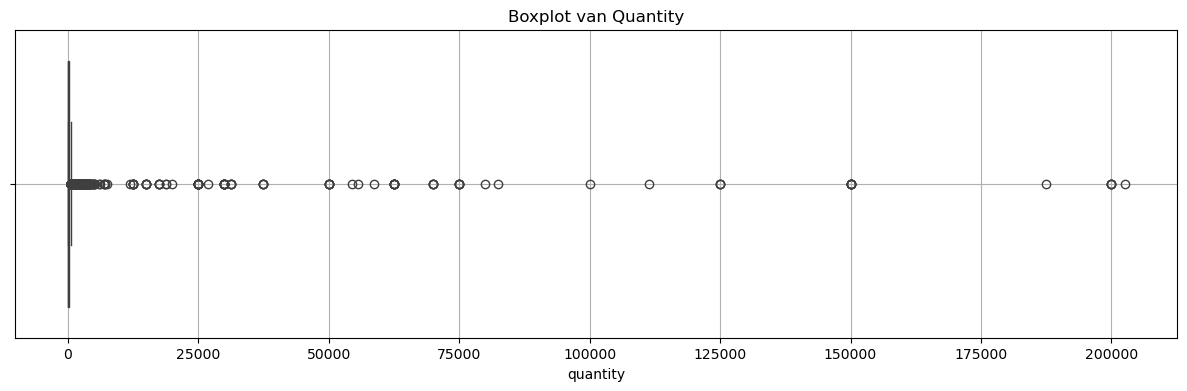

In [107]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

ingr_schoon=pd.read_csv('tabellen/data_ingr_clean.csv') 
recepten=pd.read_csv('tabellen/data_recipes.csv') 
plt.figure(figsize=(15,4))
sns.boxplot(x=ingr_schoon['quantity'])
plt.title('Boxplot van Quantity')
plt.xlabel('quantity')
plt.grid()
plt.show()


In [108]:
niet_erin = ingr_schoon[~ingr_schoon['recipe'].isin(recepten['title'])]

In [109]:
i = niet_erin.index
ingr_schoon.drop(i,inplace=True)

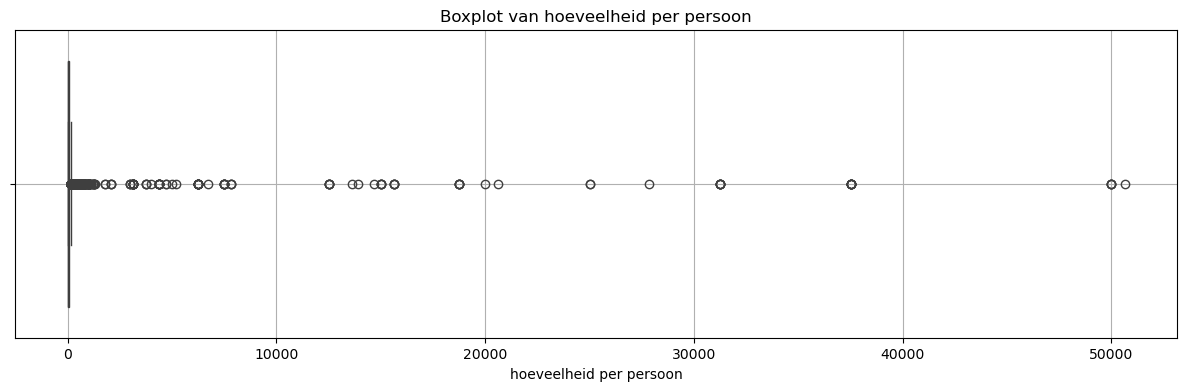

In [110]:
ingr_pp = ingr_schoon.copy().merge(recepten[['title', 'persons']], left_on='recipe', right_on='title')
ingr_pp['hoeveelheid_pp'] = ingr_pp['quantity'] / ingr_pp['persons']
ingr_pp.drop(columns=['title','persons', 'Unnamed: 0','quantity'], inplace=True)
ingr_pp = ingr_pp[['recipe','ingredient','hoeveelheid_pp','unit']]
ingr_pp
plt.figure(figsize=(15,4))
sns.boxplot(x=ingr_pp['hoeveelheid_pp'])
plt.title('Boxplot van hoeveelheid per persoon')
plt.xlabel('hoeveelheid per persoon')
plt.grid()
plt.show()

In [111]:
gr_dan =  ingr_pp.copy()[(ingr_pp['hoeveelheid_pp'] > 800)]
gr_dan

,recipe,ingredient,hoeveelheid_pp,unit
829,Quesadillatraybake,roerbakgroente,1038.000000,g
1135,Passata di pomodoro,tomaten,4000.000000,g
1332,Vijgenchutney,bruinebasterdsuiker,2083.333333,g
1333,Vijgenchutney,balsamicoazijn,2083.333333,g
1494,Zomerse kruidencocktail,bruinerum,7500.000000,g
...,...,...,...,...
46630,Broccoligratin met karbonade,broccoli,37500.000000,g
47035,Grapefruit-bosvruchtensmoothie,bosvruchtensorbetijs,15625.000000,g
47758,Risotto champignons met ham,bospaddenstoelenbouillonvantablet,50000.000000,g
49142,Frietje Vlaamse stoof,bruinbier,18750.000000,g


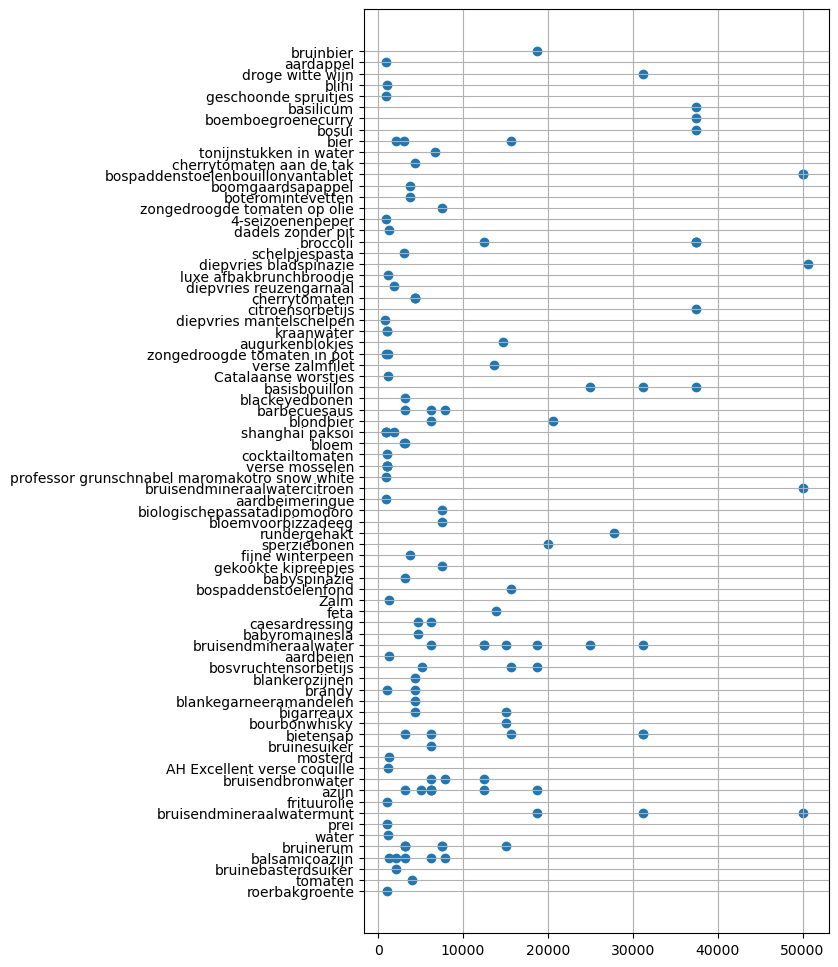

In [116]:

plt.figure(figsize=(6,12))
plt.scatter(gr_dan['hoeveelheid_pp'], gr_dan['ingredient'])
#plt.xticks(rotation = 90, ha='right')
plt.grid()
plt.show()

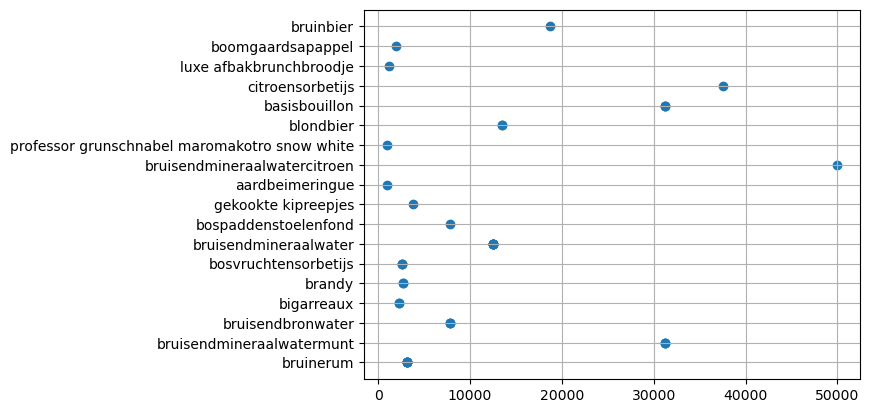

In [118]:
for i in gr_dan['ingredient']:   
    median_i = ingr_pp['hoeveelheid_pp'].loc[ingr_pp['ingredient']== i].median() #De hoeveelheden van ingredienten > 10k overzetten naar mediaan van ingredient
    gr_dan['hoeveelheid_pp'].mask(gr_dan['ingredient'] == i, median_i, inplace=True)
       
gr_dan_plot = gr_dan[(gr_dan['hoeveelheid_pp'] > 800)]
plt.scatter(gr_dan_plot['hoeveelheid_pp'], gr_dan_plot['ingredient'])
#plt.xticks(rotation = 90, ha='right')
plt.grid()
plt.show()

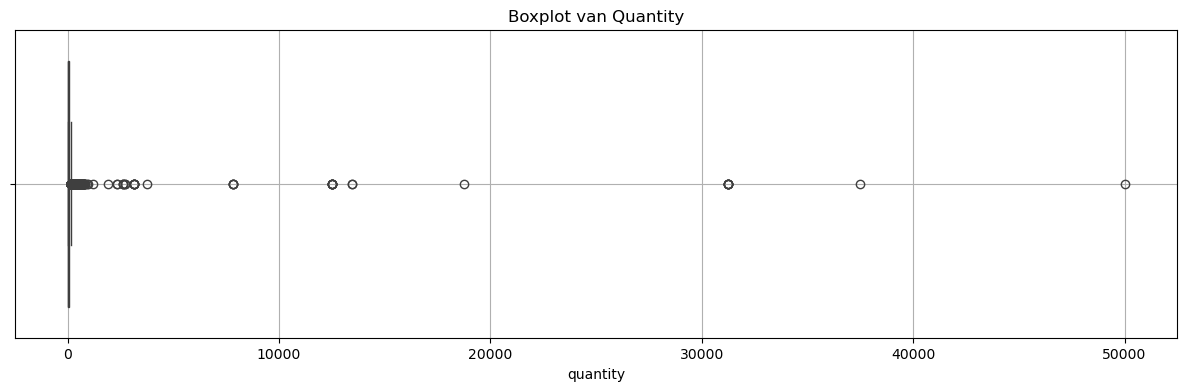

In [119]:
for i in gr_dan['ingredient']:
    quantity_i = gr_dan['hoeveelheid_pp'].loc[gr_dan['ingredient']== i]
    ingr_pp['hoeveelheid_pp'].mask(ingr_pp['ingredient'] == i, quantity_i, inplace=True)
    
plt.figure(figsize=(15,4))
sns.boxplot(x=ingr_pp['hoeveelheid_pp'])
plt.title('Boxplot van Quantity')
plt.xlabel('quantity')
plt.grid()
plt.show()

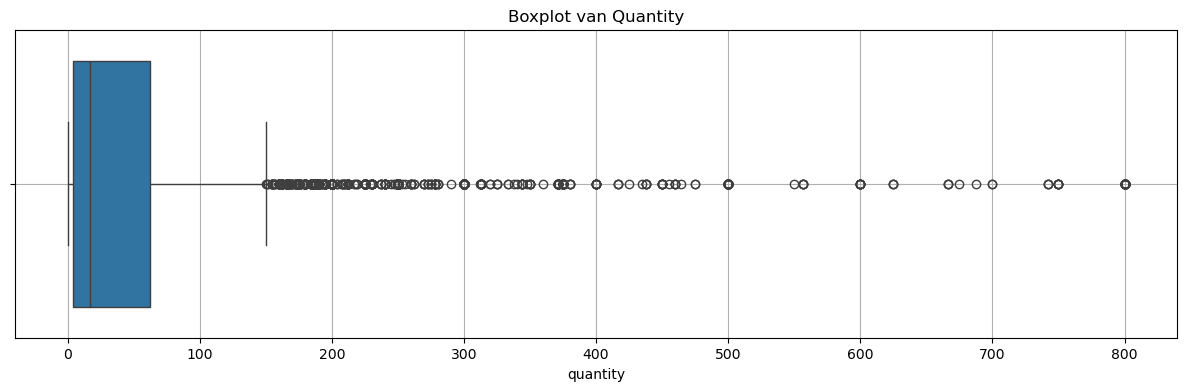

In [120]:
gr_dan2 = ingr_pp.copy()[(ingr_pp['hoeveelheid_pp'] > 800)]
for i in gr_dan2['ingredient']:
    ingr_pp['hoeveelheid_pp'].mask(ingr_pp['ingredient'] == i, 800, inplace=True) #Ingredienten > 10k vervangen door 10k

ingr_pp
plt.figure(figsize=(15,4))
sns.boxplot(x=ingr_pp['hoeveelheid_pp'])
plt.title('Boxplot van Quantity')
plt.xlabel('quantity')
plt.grid()
plt.show()

## Hypothesetoetsen
formuleer een vermoeden en bijbehorende hypothesen waarin de extra eis verwerkt is en toets het vermoeden aan de hand van de dataset. Bijvoorbeeld: over bepaalde keukens bestaan vooroordelen. Zo zou de Franse keuken veel gerechten met knoflook bevatten. Als jullie extra eis met knoflook te maken heeft zou je dus kunnen toetsen of de Franse keuken inderdaad vaker knoflook bevat dan gemiddeld.

- Denk na over een bepaalde groep recepten (een keuken, of gebruik de tags) en formuleer hier een vermoeden over.
- Zorg er daarbij voor dat je dat vermoeden op basis van de gegevens over die recepten kunt toetsen. Denk daarbij vooral aan de nutriënten of ingrediënten (in relatie met jullie extra eis).
- Formuleer dit vermoeden in de vorm van een hypothese en toets deze hypothese.

**Ons vermoeden:**
De Amerikaanse keuken bevat meer calorieën dan de Hollandse keuken.

**Onze hypothese:**  
A = de gemiddelde hoeveelheid calorieën in de Amerikaanse keuken  
H = de gemiddelde hoeveelheid calorieën in de Hollandse keuken

H_0: A <= H vs. H_1: A > H 

**Gekozen significantieniveau** 
a= 0.05

In [10]:
tags = pd.read_csv('tabellen/data_tags.csv')
nutri = pd.read_csv('tabellen/data_nutritions.csv') 

amerikaans = tags[(tags['tag'] == 'amerikaans')]
hollands = tags[(tags['tag'] == 'hollands')]

nutri_a = nutri[nutri['recipe'].isin(amerikaans['recipe'])]
nutri_h = nutri[nutri['recipe'].isin(hollands['recipe'])]

cal_a = nutri_a['value'].loc[nutri_a['nutrition']=='energie'].tolist()
cal_h = nutri_h['value'].loc[nutri_h['nutrition']=='energie'].tolist()  

h = nutri_h[(nutri_h['nutrition']=='energie')] 
h['value'].describe()
a= nutri_a[(nutri_a['nutrition']=='energie')]  
a 
h

,Unnamed: 0,recipe,nutrition,value
0,0,Kruidnoten met choco-discodip,energie,260 kcal
8,8,Kruidnoten in marsepein,energie,265 kcal
16,16,Kruidnoten met chocodips,energie,335 kcal
24,24,Pepernotentaart met marsepeinstrik,energie,560 kcal
64,87,Bloemkoolschotel,energie,765 kcal
...,...,...,...,...
40532,58270,Bietenstamppot met spek en appel,energie,595 kcal
40568,58310,Hollands draadjesvlees,energie,525 kcal
40579,58321,Kaasplank met zilveruitjes,energie,210 kcal
40830,58625,Appeljachtschotel,energie,605 kcal


In [11]:
tags=pd.read_csv('tabellen/data_tags.csv')
tags[tags['tag']=='hollands'] 

,Unnamed: 0,recipe,tag
0,0,Kruidnoten met choco-discodip,hollands
5,5,Kruidnoten in marsepein,hollands
10,10,Kruidnoten met chocodips,hollands
16,16,Pepernotentaart met marsepeinstrik,hollands
41,57,Bloemkoolschotel,hollands
...,...,...,...
32043,45677,Bietenstamppot met spek en appel,hollands
32075,45713,Hollands draadjesvlees,hollands
32083,45721,Kaasplank met zilveruitjes,hollands
32261,45941,Appeljachtschotel,hollands


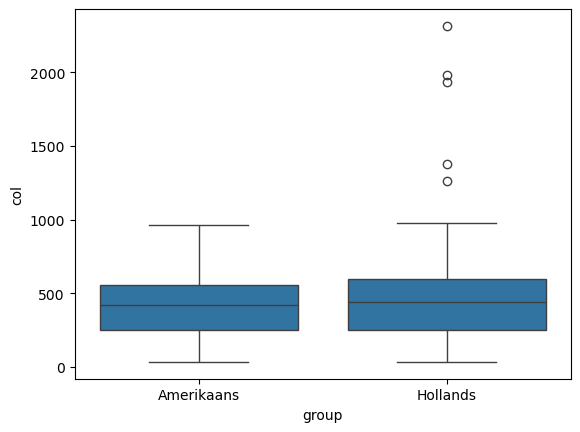

In [12]:
a= [int(i[0:-5]) for i in cal_a]  
h = [int(i[0:-5]) for i in cal_h]   

df_a = pd.DataFrame({'col':a}) 
df_h = pd.DataFrame({'col':h})  

df_a['group'] = 'Amerikaans'
df_h['group'] = 'Hollands'

combined_df = pd.concat([df_a, df_h])
sns.boxplot(x='group', y='col', data=combined_df)
plt.show()

In [13]:
ttest_ind(df_a['col'], df_h['col'], equal_var=True) 


TtestResult(statistic=-0.4427550161056866, pvalue=0.6580706089108573, df=750.0)

**Conclusie**
Uit de t-test volgt een p-waarde, die groter is dan het gekozen significantieniveau. Dit houdt in dat de nulhypothese behouden blijft, dus ons vermoeden niet klopt.

## Regressie Analyse



De nutrient waar we rekening mee zullen houden in onze analyse is: koolhydraten. Koolhydraten dragen bij aan onze eis: "het tellen van caloriën", omdat we vermoeden dat het van alle nutriënten het meest invloed heeft op het aantal caloriën.  


In [14]:
tags=pd.read_csv('tabellen/data_tags.csv') 
tags

,Unnamed: 0,recipe,tag
0,0,Kruidnoten met choco-discodip,hollands
1,1,Kruidnoten met choco-discodip,gebak
2,2,Kruidnoten met choco-discodip,gebak
3,3,Kruidnoten met choco-discodip,sinterklaas
4,4,Kruidnoten met choco-discodip,sinterklaasavond
...,...,...,...
32309,46030,Ceviche met sint-jakobsschelpen,voorgerecht
32310,46036,Biefstuk met rodewijnsaus en ham,snel
32311,46037,Biefstuk met rodewijnsaus en ham,mediterraan
32312,46038,Biefstuk met rodewijnsaus en ham,hoofdgerecht


In [121]:
ingr_pp.ingredient.value_counts()[:10]

ingredient
knoflook                  1498
middelgroot ei            1087
traditionele olijfolie    1082
ongezouten roomboter      1006
citroen                    686
milde olijfolie            653
zout                       551
water                      527
tarwebloem                 501
arachideolie               489
Name: count, dtype: int64

In [15]:
#tags_zoetig = tags[(tags['tag'] == 'gebak') | (tags['tag'] == 'sinterklaas') | (tags['tag'] == 'sinterklaasavond') | (tags['tag'] == 'kerst')| (tags['tag'] == 'pasta') | (tags['tag'] == 'oud &amp;nieuw') | (tags['tag'] == 'nagerecht') | (tags['tag'] == 'traktatie')]
# zoetig = tags[(tags['tag'] == ' tags_zoetig


In [16]:
# zoetig_i = ingr_schoon[ingr_schoon['recipe'].isin(tags_zoetig['recipe'])] 
# a= zoetig_i.ingredient.value_counts() 
# a


In [17]:
# recepten_tbs =zoetig_i[(zoetig_i['ingredient'] == 'tarwebloem') | (zoetig_i['ingredient'] == 'poedersuiker') |(zoetig_i['ingredient'] == 'middelgroot ei')]  
# recepten_tbs 

# recepten_tbs =zoetig_i[(zoetig_i['ingredient'] == 'tarwebloem') | (zoetig_i['ingredient'] == 'ongezouten roomboter') |(zoetig_i['ingredient'] == 'middelgroot ei')]  
# recepten_tbs 

In [18]:
ingr_schoon.ingredient.value_counts()[:10]

ingredient
knoflook                  1498
middelgroot ei            1087
traditionele olijfolie    1082
ongezouten roomboter      1006
citroen                    721
milde olijfolie            653
zout                       551
water                      527
tarwebloem                 501
arachideolie               489
Name: count, dtype: int64

In [122]:
recepten_eto = ingr_schoon[(ingr_schoon['ingredient'] == 'traditionele olijfolie') | 
                           (ingr_schoon['ingredient'] == 'ongezouten roomboter') | (ingr_schoon['ingredient'] == 'middelgroot ei')]
recepten_eto 

,Unnamed: 0,recipe,ingredient,quantity,unit
4,4,Kruidnoten in marsepein,ongezouten roomboter,15.0,g
8,8,Kruidnoten met chocodips,ongezouten roomboter,4.0,g
12,12,Pepernotentaart met marsepeinstrik,ongezouten roomboter,350.0,g
16,16,Pepernotentaart met marsepeinstrik,middelgroot ei,180.0,g
23,23,Perencake,middelgroot ei,180.0,g
...,...,...,...,...,...
49689,71581,Aardappelen en paprika uit de oven,traditionele olijfolie,36.0,g
49700,71602,Aardappel en knolselderij,traditionele olijfolie,48.0,g
49706,71615,Appeljachtschotel,ongezouten roomboter,50.0,g
49730,71668,Kip uit de braadzak,ongezouten roomboter,25.0,g


In [22]:
aantal_personen = recepten[recepten['title'].isin(recepten_eto['recipe'])]  
aantal_personen[:5]

,Unnamed: 0,title,persons,time,calories,stars,url,image
1,0,Kruidnoten in marsepein,4,25,265,0,https://www.ah.nl/allerhande/recept/R-R1195892...,https://static.ah.nl/static/recepten/img_RAM_P...
2,0,Kruidnoten met chocodips,4,25,335,0,https://www.ah.nl/allerhande/recept/R-R1195891...,https://static.ah.nl/static/recepten/img_RAM_P...
3,0,Pepernotentaart met marsepeinstrik,10,30,560,0,https://www.ah.nl/allerhande/recept/R-R1195887...,https://static.ah.nl/static/recepten/img_RAM_P...
4,0,Perencake,12,10,265,0,https://www.ah.nl/allerhande/recept/R-R1195790...,https://static.ah.nl/static/recepten/img_RAM_P...
6,0,Ajam pangang,4,45,515,0,https://www.ah.nl/allerhande/recept/R-R1195786...,https://static.ah.nl/static/recepten/img_RAM_P...


In [23]:
ingredienten_eto = ingr_schoon[ingr_schoon['recipe'].isin(recepten_eto['recipe'])] 
ingredienten_eto = ingredienten_eto.reset_index()
ingredienten_eto

,index,Unnamed: 0,recipe,ingredient,quantity,unit
0,3,3,Kruidnoten in marsepein,blankemarsepein,150.0,g
1,4,4,Kruidnoten in marsepein,ongezouten roomboter,15.0,g
2,5,5,Kruidnoten in marsepein,kruidnoten,60.0,g
3,6,6,Kruidnoten in marsepein,nougatine in bakje,12.0,g
4,7,7,Kruidnoten met chocodips,pure chocolade,100.0,g
...,...,...,...,...,...,...
16358,49731,71669,Kip uit de braadzak,aardappelballetjes,600.0,g
16359,49732,71670,Kip uit de braadzak,knoflook,16.0,g
16360,49733,71671,Kip uit de braadzak,witlof,600.0,g
16361,49734,71672,Kip uit de braadzak,appel,742.0,g


In [20]:
aantal_personen = recepten[recepten['title'].isin(recepten_tbs['recipe'])]  
aantal_personen[:5]

NameError: name 'recepten_tbs' is not defined

In [ ]:
ingredienten_tbs = ingr_schoon[ingr_schoon['recipe'].isin(recepten_tbs['recipe'])] 
ingredienten_tbs = ingredienten_tbs.reset_index()
ingredienten_tbs

In [ ]:
hvl_pp = []

for i in aantal_personen['title']:
    personen = aantal_personen['persons'].loc[aantal_personen['title']==i]
    hoeveelheid = ingredienten_tbs['quantity'].loc[ingredienten_tbs['recipe']==i]

    for j in hoeveelheid:
        #print(j/personen)
        hvl_pp.append(j/personen)
 
hvl_pp
hoeveelheden = [round(float(rij.iloc[0]),1) for rij in hvl_pp]    
hoeveelheden_df = pd.DataFrame(hoeveelheden, columns=['quantity_1'])
hoeveelheden_df
ingr_pp = ingredienten_tbs.merge(hoeveelheden_df, how='left',left_index=True, right_index=True)
ingr_pp['quantity'] = ingr_pp['quantity_1']
ingr_pp.drop(columns=['quantity_1'], inplace=True)
ingr_pp


In [ ]:
ingr_pp['middelgroot ei'] = (ingr_pp['ingredient'] == 'middelgroot ei').astype(int)
ingr_pp['tarwebloem'] = (ingr_pp['ingredient'] == 'tarwebloem').astype(int)
ingr_pp['ongezouten roomboter'] = (ingr_pp['ingredient'] == 'ongezouten roomboter').astype(int)
ingr_pp

In [ ]:
ingr_pp['middelgroot ei'] = (ingr_pp['middelgroot ei'] * ingr_pp['quantity'])
ingr_pp['tarwebloem'] = (ingr_pp['tarwebloem'] * ingr_pp['quantity'])
ingr_pp['ongezouten roomboter'] = (ingr_pp['ongezouten roomboter'] * ingr_pp['quantity'])
ingr_pp

In [ ]:
ingr_pp = ingr_pp[(ingr_pp['ingredient'] == 'tarwebloem') | (ingr_pp['ingredient'] == 'ongezouten roomboter') | (ingr_pp['ingredient'] == 'middelgroot ei')]  
ingr_pp

In [ ]:
nutri_recepten = nutri[nutri['recipe'].isin(ingr_pp['recipe'])]  

In [ ]:
agg_functions = {'index': 'first', 'middelgroot ei': 'sum', 'tarwebloem': 'sum', 'ongezouten roomboter': 'sum'}
ingrpp_new = ingr_pp.groupby(ingr_pp['recipe']).aggregate(agg_functions)
ingrpp_new

In [ ]:
recepten_koolhydraten = nutri_recepten[(nutri_recepten['nutrition'] == 'koolhydraten')] 

In [ ]:
ingr_plusk = ingrpp_new.merge(recepten_koolhydraten, how='left', left_on = 'recipe', right_on = 'recipe')
# ingr_pp['quantity'] = ingr_pp['quantity_1']
# ingr_pp.drop(columns=['quantity_1'], inplace=True)
# ingr_pp        
    
ingr_plusk.dropna(inplace=True) 
ingr_plusk = ingr_plusk.reset_index()
ingr_plusk.tail(50)


In [ ]:
ingr_plusk.drop(columns=['Unnamed: 0', 'nutrition', 'index'], inplace = True)  


In [ ]:
koolhy = ingr_plusk['value'].tolist()   
k = [int(i[0:-1]) for i in koolhy]    
waarde_koolhy = pd.DataFrame({'koolhydraten':k}) 
print(waarde_koolhy)  


ingr_alles = ingr_plusk.merge(waarde_koolhy, how='left', left_index = True , right_index = True )

ingr_alles.drop(columns=['value', 'level_0'], inplace = True)  

ingr_alles


In [ ]:
ingr_alles.rename(columns={'middelgroot ei': 'middelgroot_ei', 'tarwebloem': 'tarwebloem', 'ongezouten roomboter': 'ongezouten_roomboter', 'koolhydraten': 'koolhydraten'}, inplace=True) 
ingr_alles

In [ ]:
ingr_alles = ingr_alles[(ingr_alles['middelgroot_ei'] > 0 ) & (ingr_alles['tarwebloem'] > 0 ) & (ingr_alles['ongezouten_roomboter'] > 0 )]  
ingr_alles

In [ ]:
heat = sns.heatmap(ingr_alles.corr(numeric_only = True), cmap="RdYlGn", annot=True)
plt.show()

Uit deze analyse komt naar voren dat de numerieke variabele: tarwebloem een sterke invloed heeft op de koolhydraten. 

In [ ]:
ei = sns.scatterplot(y=ingr_alles.koolhydraten, x=ingr_alles.middelgroot_ei) 
ei

In [ ]:
tarwebloem = sns.scatterplot(y=ingr_alles.koolhydraten, x=ingr_alles.tarwebloem)
tarwebloem

In [ ]:
boter = sns.scatterplot(y=ingr_alles.koolhydraten, x=ingr_alles.ongezouten_roomboter)
boter

In [ ]:
model = smf.ols('koolhydraten ~ middelgroot_ei + tarwebloem + ongezouten_roomboter', data=ingr_alles)

# Hierbij schatten we het model
regres = model.fit()

# We printen de samenvatting van de regressieresultaten. 
print(regres.summary())